/astro/users/sdwyatt/anaconda3/envs/lsdb-test/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39354 instead
  warnings.warn(
/astro/users/sdwyatt/git-clones/lsdb/src/lsdb/catalog/catalog.py:129: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  ddf = self._ddf.groupby("_hipscat_index").apply(ufunc, **kwargs)
/astro/users/sdwyatt/git-clones/lsdb/src/lsdb/dask/skymap_catalog_data.py:20: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))

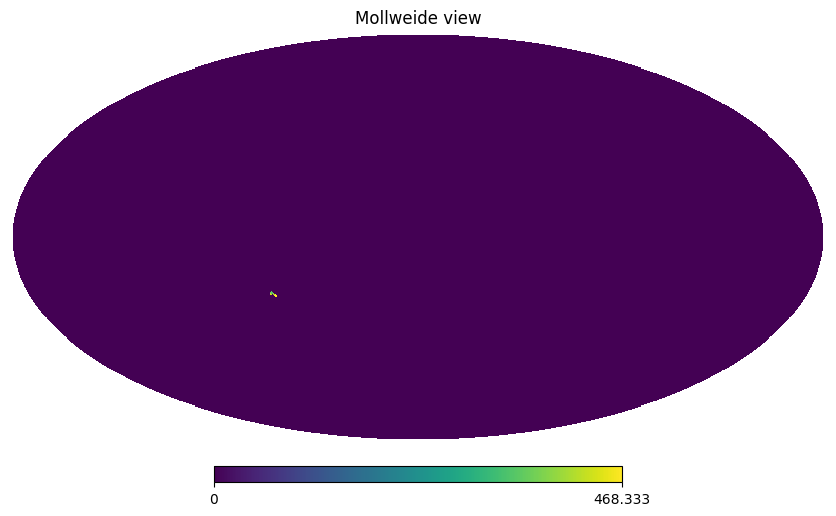

In [1]:
import lsdb
from lsdb.catalog.association_catalog.association_catalog import AssociationCatalog
from lsdb.dask.join_catalog_data import join_catalog_data

from dask.distributed import Client
import numpy as np
import pandas as pd
import healpy as hp

def count_obsv(df, cat_info) -> pd.DataFrame:
    mean_ra = np.mean(df[cat_info.ra_column])
    mean_dec = np.mean(df[cat_info.dec_column])
    count_obs = len(df)
    ret_dict = {
        "ra" : [mean_ra],
        "dec" : [mean_dec],
        "count_obsv" :[count_obs]
    }
    return pd.DataFrame(ret_dict, columns=ret_dict.keys())

ret_meta={"ra": "f8", "dec": "f8", "count_obsv": "i8"}

client = Client(n_workers=24, memory_limit='20GB', local_directory="/epyc/projects3/sam_hipscat/")
DIR = "/epyc/projects/sean_hipscat/ztf_apr_13"

a_cat = lsdb.read_hipscat(f"{DIR}/ztf_object_to_source/", catalog_type=AssociationCatalog)
object_cat = lsdb.read_hipscat(f"{DIR}/ztf_dr14")
source_cat = lsdb.read_hipscat(f"{DIR}/ztf_source/")

img = object_cat.join(source_cat, through=a_cat, suffixes=("_left", "_right"))    \
                .for_each(count_obsv)                                             \
                .compute_skymap(col="count_obsv", f=np.mean)

hp.mollview(img, nest=True)

In [19]:
type(counts)

pandas.core.frame.DataFrame

In [17]:
import numpy as np
import healpy as hp
import pandas as pd

def skymap_agg(df, col, f=np.mean):
    assert all(df["order_pix"].values == df["order_pix"].iloc[0])
    ret_dict = {
        "pix" : [df["order_pix"].iloc[0]],
        "val" : [f(df[col].values)]
    }
    return pd.DataFrame(ret_dict, columns=ret_dict.keys())

def skymap(df, col, f=np.mean, k=6):
    nside = hp.order2nside(k)
    df = df.assign(order_pix =  lambda x: hp.ang2pix(nside, x["ra"], x["dec"], lonlat=True, nest=True))
    tf = df.groupby("order_pix").apply(skymap_agg, col)
    
    npix = hp.order2npix(k)
    img = np.zeros(npix)
    img[tf["pix"].values] = tf["val"].values
    print(tf["pix"].values, tf["val"].values)
    return img

t = skymap(counts, col="count_obsv")


[34623 34652 34653 34654 34655 34665 34666 34667 34670 34671 34672 34673
 34674 34675 34676 34677 34678 34679 34680 34681 34682 34683 34684 34685
 34686 34687 34703 34707 34708 34709 34710 34711 34712 34713 34714 34715
 34716 34717 34718 34719 34723 34724 34725 34726 34727 34728 34729 34730
 34731 34732 34733 34734 34735 34736 34737 34738 34739 34740 34741 34742
 34743 34744 34745 34746 34747 34748 34749 34750 34751 34752 34753 34754
 34755 34756 34757 34758 34759 34760 34761 34762 34763 34764 34765 34766
 34767 34768 34769 34770 34771 34772 34773 34774 34775 34776 34777 34778
 34779 34780 34781 34782 34783 34784 34785 34786 34787 34788 34789 34790
 34791 34792 34793 34794 34795 34796 34797 34798 34799 34800 34801 34802
 34803 34804 34805 34806 34807 34808 34809 34810 34811 34812 34813 34814
 34815] [ 10.39047619   8.0625       7.70699476  91.63636364  56.10223901
  15.7         12.8655303   12.03382802  11.6969697   66.33918649
   7.25609756   7.58385093   7.05104408  45.73705684  70.

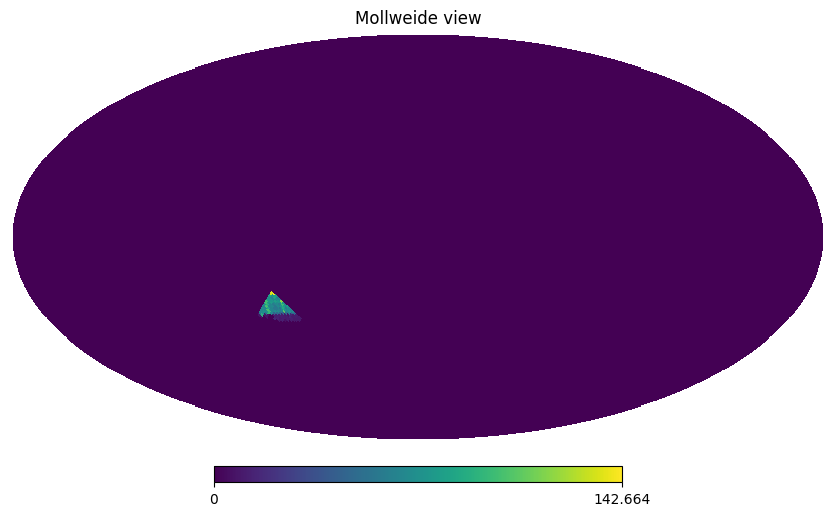

In [18]:
hp.mollview(t, nest=True)

In [ ]:
client = Client(n_workers=24, memory_limit='20GB', local_directory="/epyc/projects3/sam_hipscat/")
client

In [ ]:
DIR = "/epyc/projects/sean_hipscat/ztf_apr_13"

In [ ]:
a_cat = lsdb.read_hipscat(f"{DIR}/ztf_object_to_source/", catalog_type=AssociationCatalog)
a_cat

In [ ]:
object_cat = lsdb.read_hipscat(f"{DIR}/ztf_dr14")
object_cat.assign(t_obs=lambda x: x['nobs_g'] + x['nobs_r'] + x['nobs_i']).where('t_obs > 20 and nobs_i > 0 and nobs_g > 0 and nobs_r > 0')


In [ ]:
source_cat = lsdb.read_hipscat(f"{DIR}/ztf_source/")
source_cat

In [ ]:
joined = object_cat.join(source_cat, through=a_cat, suffixes=("_left", "_right"))
joined

In [ ]:
#joined.compute()

In [ ]:
import numpy as np
import pandas as pd

def count_obs(df, hc_structure) -> pd.DataFrame:
    mean_ra = np.mean(df['ra_left'])
    mean_dec = np.mean(df['dec_left'])
    count_obs = len(df)
    ret_dict = {
        hc_structure.catalog_info.ra_column : mean_ra,
        hc_structure.catalog_info.dec_column : mean_dec,
        "count_obs" :count_obs
    }
    return pd.DataFrame(ret_dict, columns=ret_dict.keys())

meta={"ra": "f8", "dec": "f8", "count_obs": "i8"}

joined.for_each(count_obs,  meta=meta, hc_structure=joined.hc_structure).compute()

In [ ]:
matched = object_cat.crossmatch(object_cat, suffixes=("_left", "_right"))
matched

In [ ]:
matched.compute()

In [ ]:
cm_join = object_cat.crossmatch(object_cat, suffixes=("_left", "_right"))\
                    .join(source_cat, through=a_cat, suffixes=("", "_sources"))
cm_join

In [ ]:
cm_join._ddf.visualize()

In [ ]:
cm_join.compute()

In [ ]:
cm_join._ddf.columns

In [ ]:
from hipscat.pixel_tree import PixelAlignmentType, PixelAlignment


In [ ]:
alignment = PixelAlignment.align_trees(
        left.hc_structure.pixel_tree,
        right.hc_structure.pixel_tree,
        alignment_type=PixelAlignmentType.LEFT
    )

In [ ]:
left.hc_structure.pixel_tree.pixels

In [ ]:
right.hc_structure.pixel_tree.pixels[0][8].node_type

In [ ]:

from lsdb.core.dataframe.join_catalog_data import join_catalog_data, crossmatch_catalog_data

In [ ]:
a = left.compute()

In [ ]:
pixel = left.hc_structure.get_pixels().iloc[0]
pixel